# 1) Naive Bayes

Throughout the following exercises, we're going to use Python to construct and test a Naive Bayes model with scikit-learn. 

Topics of focus include:

* Relevant import statements
* Stratification during data splitting
* Fitting a Naive Bayes model
* Evaluating the model on test data

As we move forward, we can find instructions on how to install required libraries as they arise in this notebook.

## 1.1) Modeling objective
The modeling objective is to build and test a Naive Bayes model that uses banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

### 1.1.1) Target variable
Remember, our target variable is called `Exited`. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). For each customer, our model will predict whether they should have a 0 or a 1 in the Exited column.

### 1.1.2) IMPORTANT : Model design
This is a <span style="color:red">**classification task**</span>, because we are trying to predict on a binary class. Naive Bayes often works well for this kind of task. However, recall that there are several different implementations of the Naive Bayes algorithm in scikit-learn, and each assumes that all of your predictor variables are of a single type (e.g., Gaussian for continuous variables, Bernoulli for binary variables, etc.).

Our data has all different types of predictor variables! As a data professional, one of the first things you'll learn on the job is that real-world data is never perfect. Sometimes the data breaks the assumptions of your model. In practice, you'll have to do the best you can with what you have.

In this case, if we wanted to build the best possible Naive Bayes model, we'd treat each variable according to their different types and distributions, and then combine each conditional probability to get the final prediction for each observation. That's advanced data science, and beyond the scope of this notebook.

For this lesson, we're going to use the `GaussianNB` classifier. This implementation assumes that all of your variables are continuous and that they have a Gaussian (i.e., normal) distribution. Our data doesn't perfectly adhere to these assumptions, but a Gaussian model may still yield usable results, even with imperfect data.

## 1.2) Import statements
Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using numpy and pandas for operations, and matplotlib for plotting.

Notice that we're getting `GaussianNB` from the `sklearn.naive_bayes` module. If you wanted, you could get the other implementations of Naive Bayes from this same module.

We'll also import some evaluation metrics from `sklearn.metrics` and some functions that will help us generate and plot a confusion matrix.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1.3) Read in the data
We're going to use :

* Drop the `RowNumber`, `CustomerId`, `Surname`, and `Gender` columns
* Dummy encode the `Geography` column to convert categorical to Boolean
* Engineer a new feature called `Loyalty`, by dividing each customer's tenure by their age

In [2]:
df_original = pd.read_csv("Churn_Modelling.csv")
churn_df = df_original.copy()
churn_df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
churn_df.drop(columns = ["RowNumber", "CustomerId", "Surname", "Gender"], axis=1, inplace=True)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Create Loyalty Variable
churn_df["Loyalty"] = churn_df["Tenure"] / churn_df["Age"]
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty
0,619,France,42,2,0.00,1,1,1,101348.88,1,0.047619
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,0.024390
2,502,France,42,8,159660.80,3,1,0,113931.57,1,0.190476
3,699,France,39,1,0.00,2,0,0,93826.63,0,0.025641
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0.046512


In [6]:
# Print unique values of the variable "Geography":
churn_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
# Dummy encode the cartegorical variables:
churn_df = pd.get_dummies(churn_df, drop_first= True)     #drop_first=T means replacing the geo column with only 2 column (no info is lost)
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1


## 1.4) Check the class balance

Before we begin modeling, let's do a few more things. First, we'll check the class balance of the `Exited` column, our target variable.

In [8]:
churn_df['Exited'].value_counts(normalize=True)*100

0    79.63
1    20.37
Name: Exited, dtype: float64

The class is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme.

Also, we have to remember that the Naive Bayes formula depends on class priors (P(c)) to make predictions. Because of this, performing class balancing (e.g., upsampling or downsampling) would change those terms in a way that would no longer reflect the real-world distribution of the data.

For these reasons, we'll proceed without altering the class balance of our target variable.

Drop dependent variables
Remember that Naive Bayes models operate best when there's **conditional independence between the predictor variables**. When we prepared our data, we engineered a feature called `Loyalty` by dividing `Tenure` by `Age`. Because this new feature is just the quotient of two existing variables, it's no longer conditionally independent. Therefore, we'll drop `Tenure` and `Age` to help adhere to the assumptions of our model.

## 1.5) Drop dependent variables

Remember that Naive Bayes models operate best when there's conditional independence between the predictor variables. When we prepared our data, we engineered a feature called `Loyalty` by dividing `Tenure` by `Age`. Because this new feature is just the quotient of two existing variables, it's no longer conditionally independent. Therefore, we'll drop `Tenure` and `Age` to help adhere to the assumptions of our model.

In [9]:
churn_df.drop(columns=["Tenure", "Age"], axis= 1, inplace =True)
churn_df.head()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


## 1.6) Split the data
We've prepared our data and we're ready to model. There's one last step before we can begin. We must split the data into <span style="color:red">**features**</span> and <span style="color:red">**target variable**</span>, and into <span style="color:red">**training data**</span> and <span style="color:red">**test data**</span>. We do this using the `train_test_split()` function. We'll put <span style="color:blue">25% of the data into our test set</span>, and use the <span style="color:blue">remaining 75% to train</span>  the model.

Notice below that we include the argument `stratify=y`. If our master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the y variable (our target).

The less data you have overall, and the greater your class imbalance, the more important it is to stratify when you split the data. If we didn’t stratify, then the function would split the data randomly, and we could get an unlucky split that doesn’t get any of the minority class in the test data, which means we wouldn’t be able to effectively evaluate our model. Worst of all, we might not even realize what went wrong without doing some detective work.

Lastly, we set a random seed so we and others can reproduce our work.

In [10]:
# Define the y (target) variable:
y = churn_df['Exited']

# Define the X (predictor) variables :
X = churn_df.copy()
X = X.drop(columns="Exited", axis=1)

# Split into train and test sets :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,\
                                                    stratify= y, random_state=42)

## 1.7) Modeling

### 1.7.1) Unscaled data

We're finally ready to model! Just as with linear and logistic regression, our modeling process will begin with **fitting our model to the training data**, and then using the model to **make predictions on the test data.**

In [11]:
# Fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Get the predictions on test data
y_preds = gnb.predict(X_test)

Now we can check how our model performs using the **evaluation metrics** we imported.

In [12]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


C:\Users\Badr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hmm… this isn’t very good. Our precision, recall, and F1 scores are all zero. What’s going on? Well, let’s consider our precision formula:

$$precision = \frac{\text{true positives}}{\text{false positives + true positives}}$$

 
There are two ways for the model to have a precision of zero. The first is if the numerator is zero, which would mean that our model didn’t predict any true positives.

The second is if the denominator is also zero, which would mean that our model didn’t predict any positives at all. Dividing by zero results in an undefined value, but scikit-learn will return a value of zero in this case. Depending on your modeling environment, you may get a warning that tells you there’s a denominator of zero.

We don’t have a warning, so let’s check which situation is occurring here. If we call `np.unique()` on the model's predictions and it doesn't return an array containing `[0, 1]`, we'll know it's not predicticting any churned customers.

In [13]:
# Check unique values in predictions:
np.unique(y_preds)

array([0], dtype=int64)

This confirms that the model predicted 0 (not churned) for every sample in the test data.

Consider why this might be. Perhaps we did something wrong in our modeling process, or maybe using `GaussianNB` on predictor variables of different types and distributions just doesn't make a good model. Maybe there were problems with the data.

Before we give up, maybe the data can give us some insight into what might be happening or what further steps we can take. Let's use `describe()` to inspect the X data.

In [14]:
# Get desctiptive stats for data:
X.describe()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Loyalty,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.137936,0.250900,0.247700
std,96.653299,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.089506,0.433553,0.431698
min,350.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.064516,0.000000,0.000000
50%,652.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.129032,0.000000,0.000000
75%,718.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.200000,1.000000,0.000000
max,850.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,0.555556,1.000000,1.000000


Something that stands out is that the `Loyalty` variable we created is on a vastly different scale than some of the other variables we have, such as `Balance`  or `EstimatedSalary`. The maximum value of `Loyalty` is 0.56, while the maximum for `Balance` is over 250,000—almost six orders of magnitude greater!

### 1.7.2) Scaled data

One thing that we can usually try when modeling is scaling your predictor variables. Some models require you to scale the data in order for them to operate as expected, others don't. <span style="color:red">Naive Bayes does not require data scaling</span>. However, sometimes packages and libraries need to make assumptions and approximations in their calculations. We're already breaking some of these assumptions by using the `GaussianNB` classifier on this dataset, and it may not be helping that some of our predictor variables are on very different scales. In general, scaling might not improve the model, but it probably won't make it worse. Let's try scaling our data.

We'll use a function called `MinMaxScaler`, which we'll import from the `sklearn.preprocessing` module. `MinMaxScaler` normalizes each column so every value falls in the range of `[0, 1]`. The column's maximum value would scale to 1, and its minimum value would scale to 0. Everything else would fall somewhere between. This is the formula:
   
 $${x_{scaled}} = \frac{x - x_{min}}{x_{max} - x_{min}}$$
 
**To use a scaler, you must fit it to the training data, and transform both the training data and the test data using that same scaler.**

Let's apply this and retrain the model.

In [15]:
# import scarle function
from sklearn.preprocessing import MinMaxScaler

# initiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training data
X_train = scaler.transform(X_train)

# Scale the test data
X_test = scaler.transform(X_test)

Now we'll repeat the steps to fit our model, only this time we'll fit it to our new scaled data.

In [16]:
# Fit the model
gnb_scaled = GaussianNB()
gnb_scaled.fit(X_train, y_train)

# Get the predictors on test data
scaled_preds = gnb_scaled.predict(X_test)

In [17]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, scaled_preds))
print('Precision:', '%.3f' % precision_score(y_test,scaled_preds))
print('Recall:', '%.3f' % recall_score(y_test, scaled_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, scaled_preds))

Accuracy: 0.806
Precision: 0.544
Recall: 0.303
F1 Score: 0.389


It works now! The model is far from perfect, but at least it's predicting churned customers now.

## 1.8) Evaluation

Let's examine more closely how our model classified the test data. We'll do this with a **confusion matrix**. Recall that a :

<ins><span style="color:blue">**Confusion matrix :**</span></ins> is a graphic that shows your models true and false positives, and true and false negatives.

We can do this using the `ConfusionMatrixDisplay` and `confusion_matrix` functions that we imported, here's a helper function that will allow us to plot a confusion matrix for our model.

In [18]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Return a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_,
                                 )
  
    disp.plot(values_format='') # `values_format=''` suppresses scientific notation
    plt.show()

In [19]:
gnb_scaled.class_count_


array([5972., 1528.])

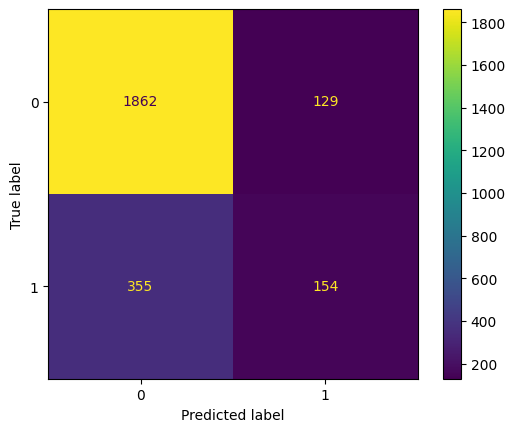

In [20]:
conf_matrix_plot(gnb_scaled, X_test, y_test)

All of our model metrics can be derived from the confusion matrix, and each metric tells its own part of the story. What stands out most in the confusion matrix is that <span style="color:red">the model misses a lot of customers who will churn. In other words, there are a lot of false negatives (355)</span>, to be exact. This is why our recall score is only 0.303.

Would we use this model? It depends. For one thing, we'd certainly want to develop other models to see if they perform better.